In [19]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

In [20]:
# apt-get update && apt-get install libgl1
%matplotlib inline

In [32]:
image_height, image_width = 1080, 1920

In [22]:
def plot_keypoints(image, keypoints, radius=3, color=(0, 255, 0)):
    """Plot keypoints on the image."""
    for x, y, in keypoints:
        cv2.circle(image, (int(x), int(y)), radius, color, -1)
    return image
    
def filter_visible(kps):
    result = []
    for i in range(0, len(kps) - 2, 3):
        x, y, z = kps[i:i+3]
        if z != 0:
            result.append((x, y))
    return result

def visualize_image_with_keypoints(dataset, img_id):
    img_path = f'./keypoints_dataset/keypoints_dataset/{dataset}/{img_id}.jpg'
    keypoints_path = f'./keypoints_dataset/keypoints_dataset/{dataset}/{img_id}.txt'
    plot_image_with_keypoints(img_path, keypoints_path)

def plot_image_with_keypoints(image_path, keypoints_file_path=None):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # If keypoints_file_path is not provided, assume it's the same as image_path but with .txt extension
    if keypoints_file_path is None:
        keypoints_file_path = os.path.splitext(image_path)[0] + '.txt'

    # Read keypoints from the file
    try:
        with open(keypoints_file_path, 'r') as f:
            keypoints_data = f.read().strip().split()
    except UnicodeDecodeError:
        print(f"Error: {keypoints_file_path} is not a valid text file. Please provide the correct path to the keypoints file.")
        return
    except FileNotFoundError:
        print(f"Error: Keypoints file not found at {keypoints_file_path}")
        return

    # Extract keypoints (YOLO v8 pose format)
    keypoints_data = [float(x) for x in keypoints_data[1:]]  # Skip class index
    bbox = np.array(keypoints_data[:4])
    print(keypoints_data[4:])
    keypoints = np.array(keypoints_data[4:]).reshape(-1, 3)
    
    non_origin_mask = np.any(keypoints != 0.0, axis=1)
    count = np.sum(non_origin_mask)
    print(f'Found {count} visible points out of {len(keypoints)}')

    # Get image dimensions
    height, width = image.shape[:2]

    # Scale bbox and keypoints to image dimensions
    bbox[0:2] = bbox[0:2] - bbox[2:4] / 2  # xy top-left corner
    bbox[2:4] = bbox[0:2] + bbox[2:4]  # xy bottom-right corner
    bbox = bbox * np.array([width, height, width, height])
    keypoints[:, 0] *= width
    keypoints[:, 1] *= height

    # Plot the image
    # plt.figure(figsize=(12, 8))
    plt.imshow(image)

    # Plot keypoints
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.488889, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.132812, 0.452778, 2.0, 0.15, 0.566667, 2.0, 0.195312, 0.852778, 2.0, 0.0, 0.0, 0.0, 0.117188, 0.361111, 2.0, 0.539062, 0.358333, 2.0, 0.596875, 0.402778, 2.0, 0.682812, 0.469444, 2.0, 0.789062, 0.55, 2.0, 0.7, 0.425, 2.0, 0.704688, 0.383333, 2.0, 0.832812, 0.458333, 2.0, 0.632812, 0.305556, 2.0, 0.695312, 0.341667, 2.0, 0.759375, 0.375, 2.0, 0.89375, 0.447222, 2.0, 1.0, 0.508333, 2.0, 0.0, 0.0, 0.0]
Found 17 visible points out of 32


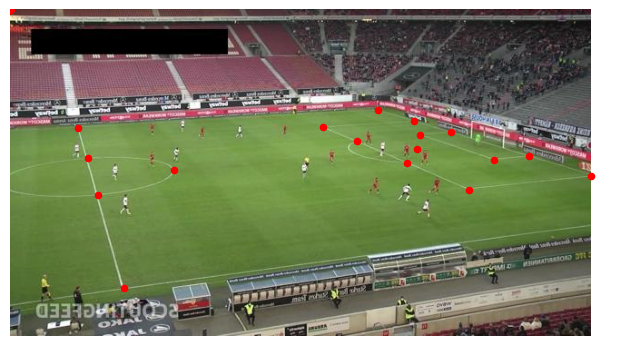

In [23]:
visualize_image_with_keypoints('valid_resized-copy', '0bfacc_1_11_png.rf.8e97f8ee3136fc375bf53a33eaa74dbf_h')

In [1]:
# Define the class mappings for flips
horizontal = {
    1:27,
    2:28,
    3:29,
    4:30,
    5:31,
    6:32,
    7:25,
    8:26,
    9:24,
    10:20,
    11:21,
    12:22,
    13:23,
    14:19,
    15:15,
    16:16,
    17:17,
    18:18
}
vertical = {
    1:6,
    2:5,
    3:4,
    7:8,
    9:9,
    10:13,
    11:12,
    14:14,
    15:18,
    16:17,
    19:19,
    20:23,
    21:22,
    24:24,
    25:26,
    29:30,
    28:31,
    27:32
}

horizontal_map, vertical_map = {}, {}
for k,v in horizontal.items():
    horizontal_map[k] = v
    horizontal_map[v] = k
for k,v in vertical.items():
    vertical_map[k] = v
    vertical_map[v] = k

horizontal_flip_map, vertical_flip_map = {}, {}
for k,v in horizontal_map.items():
    horizontal_flip_map[k-1] = v-1
for k,v in vertical_map.items():
    vertical_flip_map[k-1] = v-1

In [2]:
len(vertical_flip_map), len(vertical_flip_map)

(32, 32)

In [3]:
horizontal_flip_map

{0: 26,
 26: 0,
 1: 27,
 27: 1,
 2: 28,
 28: 2,
 3: 29,
 29: 3,
 4: 30,
 30: 4,
 5: 31,
 31: 5,
 6: 24,
 24: 6,
 7: 25,
 25: 7,
 8: 23,
 23: 8,
 9: 19,
 19: 9,
 10: 20,
 20: 10,
 11: 21,
 21: 11,
 12: 22,
 22: 12,
 13: 18,
 18: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17}

In [26]:
def resize_images(input_dir, output_dir, new_size=(640, 360)):
    for filename in os.listdir(input_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            with Image.open(os.path.join(input_dir, filename)) as img:
                resized_img = img.resize(new_size)
                resized_img.save(os.path.join(output_dir, filename))

# Usage
# resize_images('./keypoints_dataset/train', './keypoints_dataset/train_resized')
# resize_images('./keypoints_dataset/valid', './keypoints_dataset/valid_resized')
# resize_images('./keypoints_dataset/test', './keypoints_dataset/test_resized')

In [31]:
def scale_keypoints(keypoints, scale_x=1/3, scale_y=1/3):
    scaled_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i:i+3]
        scaled_keypoints.extend([int(x * scale_x), int(y * scale_y), v])
    return scaled_keypoints

def flip_keypoints(keypoints, mode):
    # Ensure keypoints is a numpy array
    keypoints = np.array(keypoints).reshape(-1, 3)
    
    # Create an array to store flipped keypoints
    flipped_keypoints = np.zeros_like(keypoints)
    for i in range(len(keypoints)):
        # Find the corresponding flipped keypoint index        
        if mode == 'horizontal':
            flipped_x, flipped_y = image_width - keypoints[i, 0], keypoints[i,1]
            flipped_index = horizontal_flip_map[i]
        elif mode == 'vertical':
            flipped_x, flipped_y = keypoints[i, 0],  image_height - keypoints[i, 1]
            flipped_index = vertical_flip_map[i]
        else:
            flipped_x, flipped_y = keypoints[i, 0], keypoints[i, 1]
        # Store the flipped keypoint at the correct position
        flipped_keypoints[flipped_index, 0] = flipped_x
        flipped_keypoints[flipped_index, 1] = flipped_y
        flipped_keypoints[flipped_index, 2] = keypoints[i, 2]
    
    # Flatten the array back to the original shape
    return flipped_keypoints.flatten()


def handle_for_keypoints(keypoints, output_dir, img_name):
    # Calculate bounding box
    x_coords = [keypoints[i] for i in range(0, len(keypoints), 3) if keypoints[i+2] > 0]
    y_coords = [keypoints[i+1] for i in range(0, len(keypoints), 3) if keypoints[i+2] > 0]

    if not x_coords or not y_coords:
        return  # Skip if no visible keypoints
    
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    
    # Calculate normalized center coordinates and dimensions
    x_center = (x_min + x_max) / (2 * image_width)
    y_center = (y_min + y_max) / (2 * image_height)
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height

    filename = img_name + ".txt"
    with open(os.path.join(output_dir, filename), 'w') as f:
        # Write class_id, bounding box info
        f.write(f"0 {x_center} {y_center} {width} {height}")

        # print(f'Len of keypoints to handle {len(keypoints)}')
        # Write keypoints
        for i in range(0, len(keypoints), 3):
            x, y, v = keypoints[i:i+3]
            if v == 0:
                x, y = 0., 0.
            x_norm = round(x / image_width, 6)
            y_norm = round(y / image_height, 6)
            f.write(f" {x_norm} {y_norm} {v}")
        f.write("\n")

def save_flipped_image(output_dir, flip_type, image_name):
    # Construct the full path to the input image
    input_path = os.path.join(output_dir, image_name+".jpg")
    
    # Open the image
    with Image.open(input_path) as img:
        if flip_type == 'horizontal':
            flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
            suffix = '_h'
        elif flip_type == 'vertical':
            flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)
            suffix = '_v'
        else:
            raise ValueError("flip_type must be either 'horizontal' or 'vertical'")
        
        new_filename = f"{image_name}{suffix}.jpg"
        
        # Construct the full path for the output image
        output_path = os.path.join(output_dir, new_filename)
        
        # Save the flipped image
        flipped_img.save(output_path, 'JPEG')

def convert_coco_to_yolo(coco_file, output_dir, image_width=640, image_height=360):
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)
    
    images = {img['id']: img['file_name'] for img in coco_data['images']}

    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        image_name = os.path.splitext(images[image_id])[0]
        keypoints = scale_keypoints(ann['keypoints'], scale_x=1., scale_y=1. )
        # print(keypoints)
        handle_for_keypoints(keypoints, output_dir, image_name)

        v_flipped_keypoints = flip_keypoints(keypoints, 'vertical')
        save_flipped_image(output_dir, 'vertical', image_name)
        handle_for_keypoints(v_flipped_keypoints, output_dir, image_name + "_v")

        h_flipped_keypoints = flip_keypoints(keypoints, 'horizontal')
        save_flipped_image(output_dir, 'horizontal', image_name)
        handle_for_keypoints(h_flipped_keypoints, output_dir, image_name + "_h")
        break


In [34]:
# convert_coco_to_yolo('./keypoints_dataset/keypoints_dataset/train/_annotations.coco.json', './keypoints_dataset/keypoints_dataset/train')
# convert_coco_to_yolo('./keypoints_dataset/keypoints_dataset/valid/_annotations.coco.json', './keypoints_dataset/keypoints_dataset/valid')

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.953125, 0.458333, 2.0, 0.584375, 0.430556, 2.0, 0.101562, 0.213889, 2.0, 0.014062, 0.266667, 2.0, 0.0, 0.0, 0.0, 0.042188, 0.45, 2.0, 0.0, 0.0, 0.0, 0.014062, 0.386111, 2.0, 0.003125, 0.322222, 2.0, 0.1625, 0.347222, 2.0, 0.76875, 0.375, 2.0, 0.75625, 0.527778, 2.0, 0.726562, 0.925, 2.0, 0.2375, 0.280556, 2.0, 0.778125, 0.25, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Found 13 visible points out of 32


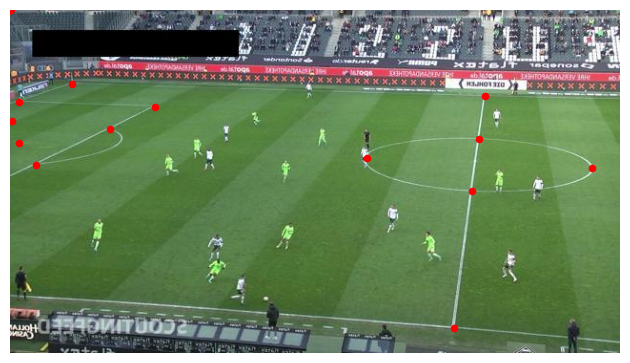

In [9]:
visualize_image_with_keypoints('train_resized', '08fd33_4_1_png.rf.aa7acccbcc1190786d0858d2f1e62782_h')

In [10]:
model = YOLO('last.pt')
# results = model.train(
#     device='cuda',
#     data='./keypoints.yaml',
#     epochs=500,
#     imgsz=640,
#     batch=32,
# )

In [45]:
def visualize_model_prediction(model, image_path):
    """Visualize model prediction on the image."""
    # Run inference
    results = model(image_path, conf=0.25)
    
    # Read image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Get keypoints
    keypoints = results[0].keypoints.xy[0].cpu().numpy()
    print(keypoints)
    # Plot keypoints
    image = plot_keypoints(image, keypoints, color=(255, 0, 0))
    
    # Display image
    # plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.show()

In [12]:
# model.trainer.save_model()


image 1/1 /Users/cosmincojocaru/keypoints_football/keypoints_football/keypoints_dataset/keypoints_dataset/valid_resized/e624c9_7_2_png.rf.1bcde8dff582918520f65258701075f3_h.jpg: 384x640 1 keypoints, 190.4ms
Speed: 0.9ms preprocess, 190.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


(360, 640, 3)
[[          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [     482.36      152.07]
 [     285.67       144.8]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [     408.32      77.803]
 [     401.01      122.99]
 [     391.69      183.72]
 [     365.48      355.15]
 [     77.527      87.165]
 [     405.33      74.704]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]
 [          0           0]]


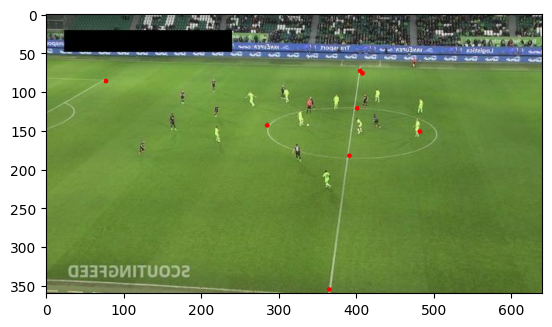

In [47]:
visualize_model_prediction(model, './keypoints_dataset/keypoints_dataset/valid_resized/e624c9_7_2_png.rf.1bcde8dff582918520f65258701075f3_h.jpg')